First load scraping results and model from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

path_to_scraping_results='drive/My Drive/Seminar/results'
roberta_base_transformers='drive/My Drive/Seminar/roberta_base_transformers'

In [ ]:
!cp 'drive/My Drive/Seminar/tfidf_vectorizer.pkl' .
!cp 'drive/My Drive/Seminar/xgb_model.pkl' .
!cp 'drive/My Drive/Seminar/saved_weights.pt' .

!cp 'drive/My Drive/Seminar/roberta_base_transformers.zip' .
!unzip 'roberta_base_transformers.zip' -d  'roberta'

Archive:  roberta_base_transformers.zip
  inflating: roberta/config.json     
  inflating: roberta/pytorch_model.bin  
  inflating: roberta/tokenizer.json  


In [ ]:
!ls roberta

config.json  pytorch_model.bin	tokenizer.json


In [ ]:
!ls .

drive	 roberta			sample_data	  tfidf_vectorizer.pkl
results  roberta_base_transformers.zip	saved_weights.pt  xgb_model.pkl


In [ ]:
!pip install transformers
!pip install xgboost

import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
import os
from transformers import RobertaModel, AutoModel, PreTrainedTokenizerFast

from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb

import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score


     |████████████████████████████████| 1.3MB 5.8MB/s 
     |████████████████████████████████| 2.9MB 28.8MB/s 
     |████████████████████████████████| 890kB 29.7MB/s 
     |████████████████████████████████| 1.1MB 31.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9a2b11b913fd5f6c37b35694ee5af19a489f58b496caec17c82787314d8ebaa2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
with open ('results', 'rb') as fp:
    itemlist = pickle.load(fp)

In [ ]:
X_list = itemlist['x_original']
Y_list = itemlist['y']

In [ ]:
print('X_list:', len(X_list), 'Y_list:', len(Y_list), '\n')

print('Przykładowe zawartości stron\n')
# print(X_list[29][:120])
# print(X_list[27][:120])

X_list: 5 Y_list: 5 

Przykładowe zawartości stron



In [ ]:
with open('xgb_model.pkl', 'rb') as model_xgb_file:
  model_xgb = pickle.load(model_xgb_file)

with open('tfidf_vectorizer.pkl', 'rb') as tfidf_vectorizer_file:
  vectorizer = pickle.load(tfidf_vectorizer_file)

X = vectorizer.transform(X_list)
print(len(vectorizer.get_feature_names()))

X_tfidf, Y_tfidf = np.array(X.todense()), np.array(Y_list).astype(int)

D_test = xgb.DMatrix(X_tfidf, label=Y_tfidf)

26291


In [ ]:
test_text, test_labels = np.array(X_list), np.array(Y_list).astype(int)

In [ ]:
from transformers import RobertaTokenizerFast
model_dir = "roberta"
tokenizer = PreTrainedTokenizerFast(tokenizer_file=os.path.join(model_dir, "tokenizer.json"))
tokenizer.pad_token = '<pad>'
roberta: RobertaModel = AutoModel.from_pretrained(model_dir)

In [ ]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 500,
    truncation=True,
    padding=True
)

In [ ]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# specify GPU
device = torch.device("cuda")

In [ ]:

# freeze all the parameters
for param in roberta.parameters():
    param.requires_grad = False

In [ ]:
class ROBERTa_Arch(nn.Module):

    def __init__(self, roberta_):
      
      super(ROBERTa_Arch, self).__init__()

      self.roberta = roberta_
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.roberta(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = ROBERTa_Arch(roberta)

# push the model to GPU
model = model.to(device)

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds

array([[-0.65719855, -0.73043644],
       [-0.17392871, -1.8348141 ],
       [-0.98912096, -0.4650614 ],
       [-0.5947406 , -0.80230516],
       [-0.04648434, -3.0917928 ]], dtype=float32)

In [ ]:
test_y

tensor([0, 0, 0, 0, 0])

In [ ]:
print('ROBERTA')
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

ROBERTA


AxisError: ignored

In [ ]:
print('Most common value only')
print(classification_report(test_y, np.zeros(preds.shape[0], dtype=int)))

Most common value only
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [ ]:
preds_xgb = model_xgb.predict(D_test)
best_preds_xgb = np.asarray([np.argmax(line) for line in preds_xgb])
print('XGB model')
print(classification_report(best_preds_xgb, Y_tfidf))

XGB model
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
best_preds_xgb

array([0, 0, 0, 1, 0])

In [ ]:
preds

array([0, 0, 1, 0, 0])

In [ ]:
import pandas as pd

y_actu = pd.Series(test_y, name='Actual')
y_pred = pd.Series(preds, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred)
print('ROBERTA')
df_confusion

ROBERTA


Predicted,0,1
Actual,,
0,4,1


In [ ]:
import pandas as pd

y_actu = pd.Series(test_y, name='Actual')
y_pred = pd.Series(best_preds_xgb, name='Predicted')

df_confusion_XGB = pd.crosstab(y_actu, y_pred)
print('XGB')
df_confusion_XGB

XGB


Predicted,0,1
Actual,,
0,4,1


In [ ]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.coolwarm):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

ROBERTA


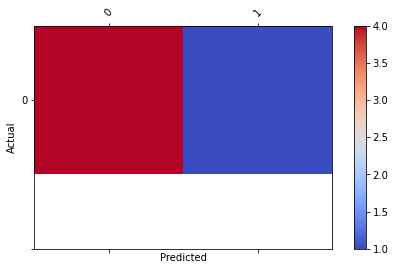

In [ ]:
print('ROBERTA')
plot_confusion_matrix(df_confusion)

XGB


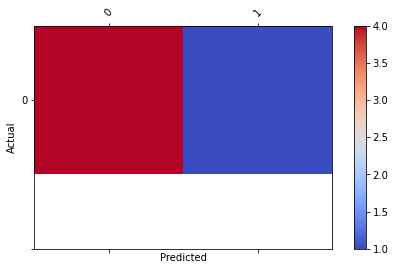

In [ ]:
print('XGB')
plot_confusion_matrix(df_confusion_XGB)